In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

import matplotlib.animation as animation

In [2]:
def Func(x1, x2):
    r = np.sqrt((x1 - np.pi)**2 + (x2 - np.pi)**2)
    if r==0:
        return 0
    elif r > 0 and r < np.pi/2:
        return 10*np.exp(-1/r)*np.exp(-1/((np.pi/2) - r))
    else:
        return 0

def gamma(x1, x2):
    return 0.01*(1 + Func(x1,x2))

def phi0(x1, x2):
    return pow(np.sin(2*x1),2) + (x2*0)

In [3]:
dx = np.pi/64
dy = np.pi/64
x1 = np.arange(0, 2*np.pi, dx)
x2 = np.arange(0, 2*np.pi, dy)
nx = len(x1)
ny = len(x2)
X1, X2 = np.meshgrid(x1, x2)
print(nx)
print(ny)

128
128


In [4]:
u1 = np.zeros((nx,ny))
u2 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        u1[i,j] = -(x2[j]-np.pi)*Func(x1[i],x2[j])
        u2[i,j] = (x1[i]-np.pi)*Func(x1[i],x2[j])
phi = phi0(X1, X2)

In [5]:
A = np.eye(nx)
alpha = 1/4
for i in range(nx-1):
    A[i,i+1] = 1/4
    A[i+1,i] = 1/4
    
A[0,ny-1] = alpha
A[nx-1,0] = alpha

In [6]:
def pade1(phi, A):

    RHS = np.zeros((nx, ny, 2))
    dPhi = np.zeros((nx,ny,2))
    phi = phi.T
    for i in range(nx-1):
        for j in range(ny-1):
            RHS[i,j, 0] = (3/4)*(phi[i+1, j]-phi[i-1, j])/dx      # x1-component
            RHS[i,j, 1] = (3/4)*(phi[i, j+1]-phi[i, j-1])/dx      # x2-component

    #last entry for x1 direction
    RHS[nx-1,:,0] = (3/4)*(phi[0,:]-phi[nx-2,:])/dx
    # first and last entry for x1 direction
    RHS[:,nx-1,1] = (3/4)*(phi[:,0]-phi[:,nx-2])/dx
    
    dPhi[:,:,0] = np.linalg.solve(A, RHS[:,:,0])     # so now this is the x1 component
    dPhi[:,:,1] = np.linalg.solve(A, RHS[:,:,1])      # and this is the x2 component
    # reason for transpose is the gamma calc needs it 
    return np.transpose(dPhi, [1,0,2])

In [7]:
def pade2(dPhi, gamma, A):
    
    d2_RHS = np.zeros((nx,ny,2))
    d2_Phi = np.zeros((nx,ny,2))
    dPhi_Gamma = np.zeros((nx,ny,2))

    for i in range(nx):
        for j in range(ny):
            dPhi_Gamma[i,j,0] = gamma(x1[i], x2[j])*dPhi[i,j,0]    # dPhi_gamma_x1
            dPhi_Gamma[i,j,1] = gamma(x1[i], x2[j])*dPhi[i,j,1]    # dPhi_gamma_x2    
    #undo transpose from dot product
    dPhi_Gamma = np.transpose(dPhi_Gamma, [1,0,2])
    for i in range(nx-1):
        for j in range(ny-1):
            d2_RHS[i,j,0] = (3/4)*(dPhi_Gamma[i+1,j,0]-dPhi_Gamma[i-1,j,0])/dx     #  x1-component
            d2_RHS[i,j,1] = (3/4)*(dPhi_Gamma[i,j+1,1]-dPhi_Gamma[i,j-1,1])/dx     #  x2-component

    # last entry for x1 direction (Note: first entry handled by python)
    d2_RHS[nx-1,:,0] = (3/4)*(dPhi_Gamma[0,:,0]-dPhi_Gamma[nx-2,:,0])/dx
    # last entry for x2 direction (Note: first entry handled by python)
    d2_RHS[:,nx-1,1] = (3/4)*(dPhi_Gamma[:,0,1]-dPhi_Gamma[:,nx-2,1])/dx
    
    d2_Phi[:,:,0] = np.linalg.solve(A, d2_RHS[:,:,0])    # this is d/dx1(gamma*dphi/dx1)
    d2_Phi[:,:,1] = np.linalg.solve(A, d2_RHS[:,:,1])    # this is d/dx2(gamma*dphi/dx2)  
    
    # transpose again to get back to form we started w in phi (should have done this better)
    return np.transpose(d2_Phi, [1,0,2])

In [8]:
def euler_step(phi, A, gamma, pade1, pade2, t_final=1, dt=.001):
    phi_array = []
    nt = int(t_final/dt)
    
    for i in range(nt):
        phi_old = phi
        
        dPhi = pade1(phi,A)
        phi = phi + dt*(-u1.T*dPhi[:,:,0] -u2.T*dPhi[:,:,1] + pade2(dPhi,gamma, A)[:,:,0] + pade2(dPhi,gamma, A)[:,:,1])
        phi_array.append(phi)
        
        if i%50==0:
            print(f'timestep: {i}/{nt}')

    return phi, phi_array

In [9]:
phi, phi_array = euler_step(phi, A, gamma, pade1, pade2)

timestep: 0/1000
timestep: 50/1000
timestep: 100/1000
timestep: 150/1000
timestep: 200/1000
timestep: 250/1000
timestep: 300/1000
timestep: 350/1000
timestep: 400/1000
timestep: 450/1000
timestep: 500/1000
timestep: 550/1000
timestep: 600/1000
timestep: 650/1000
timestep: 700/1000
timestep: 750/1000
timestep: 800/1000
timestep: 850/1000
timestep: 900/1000
timestep: 950/1000


In [10]:
phi[round(np.pi*5/(4*dx)),round(np.pi/dx)]

0.6968710565170761

(1000, 128, 128)


<IPython.core.display.Javascript object>


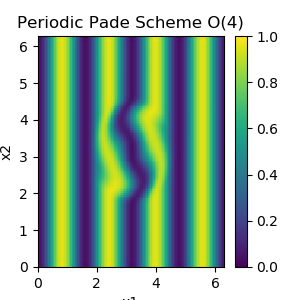

......

In [11]:
fps = 200
nSeconds = 5
snapshots1 = phi_array
print(np.shape(snapshots1))
fig = plt.figure( figsize=(3,3) )

a = snapshots1[0]
im = plt.imshow(a, interpolation='nearest', aspect='auto', origin='lower', extent=[0,2*np.pi,0,2*np.pi])
fig.colorbar(im)
def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots1[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Periodic Pade Scheme O(4)')
#anim.save('Question1_Visuals/dt_Pade_periodic_128.mp4')

In [12]:
# %matplotlib inline

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(X1, X2, phi, 50, cmap='binary')
# ax.set_xlabel('x1')
# ax.set_ylabel('x2')
# ax.set_zlabel('phi')
# plt.title("phi at t=1")
# plt.show()

In [13]:
# %matplotlib inline
# plt.imshow(phi, interpolation='nearest', origin='lower', extent=[0,2*np.pi,0,2*np.pi])
# plt.scatter(np.pi, np.pi*5/4, color='r', label='$(\pi, \pi*5/4)$')
# plt.title("Periodic Pade t=1")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend()
# plt.colorbar()
# plt.savefig("Question1/t1_periodic.png")
# plt.show()